# This code is to run the agent described in src for quick iteration, rather than trying to keep webagent_tutorial up to date all the time

## First some basic imports to set up the environment 

In [1]:
import os
import numpy as np
import nest_asyncio
import asyncio

project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))

# Presuming your directory structure is the default git one, this is set up to run in the main web-agent folder, so cd up one:
if "src" not in os.listdir():
    os.chdir("..")

nest_asyncio.apply() # to allow asynchronous calls in a jupyter notebook

In [2]:
from playwright.async_api import async_playwright

async def reset_playwright():
    try:
        playwright = await async_playwright().start()
        await playwright.stop()
    except Exception as e:
        print(f"Error resetting Playwright: {e}")

await reset_playwright()


### Now things that are more specific to our project

In [3]:
from src.agents import WebAgent
from langchain_groq import ChatGroq

/home/ben1sheff/mambaforge/envs/webagent/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Making it so that we print out the prompt at each step

In [4]:
from langchain_core.runnables import Runnable

# Define a custom logging step to print the prompt
class PrintRunnable(Runnable):
    def invoke(self, input, config, **kwargs):
        print("Formatted prompt before sending to LLM:")
        if type(input) == str:
            print(input)
        else:
            for message in input.messages:
                print(message.content)  # Print the formatted input to check
        return input 
    
    # async def ainvoke(self, input, config, **kwargs):
    #     print("Formatted prompt before sending to LLM:")
    #     for message in input.messages:
    #         print(message.content)  # Print the formatted input to check
    #     return input  # Pass the input to the next step in the pipeline
    
print_runnable = PrintRunnable()
llm = print_runnable | ChatGroq(model="llama-3.2-90b-vision-preview")


### Experimenting with writing prompts

In [5]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate, PromptTemplate
from langchain_core.prompts.image import ImagePromptTemplate
from langchain_core.messages.system import SystemMessage
# Define a partial variable for the chatbot to use
my_partial_variable = """APPLE SAUCE"""

# Initialize your chat template with partial variables
prompt_messages = [
    # System message
    SystemMessage(content=("""You are a hungry, hungry bot""")),
    # Instructions for the chatbot to set context and actions
    HumanMessagePromptTemplate(
        prompt=PromptTemplate(
            template="""Your life goal is to search for some {conversation_topic}. If you encounter food in the conversation below, please eat it:\n###\n{conversation}\n###\nHere is the food: {my_partial_variable}""",
            input_variables=["conversation_topic", "conversation"],
            partial_variables={"my_partial_variable": my_partial_variable},
        )
    ),
    ("user", [{"type": "image_url", "image_url": "hello world"}]),
    ("human", "and now we have a goal {conversation_topic}"),
    # ImagePromptTemplate(**{"type": "image_url", "image_url": "hello world"}),
    # Placeholder for additional agent notes
    MessagesPlaceholder("agent_scratchpad"),
]

prompt = ChatPromptTemplate(messages=prompt_messages)
prompt_as_string = prompt.format(
    conversation_topic="Delicious food",
    conversation="Nothing about food to see here",
    agent_scratchpad=[],
)
print(prompt_as_string)

System: You are a hungry, hungry bot
Human: Your life goal is to search for some Delicious food. If you encounter food in the conversation below, please eat it:
###
Nothing about food to see here
###
Here is the food: APPLE SAUCE
Human: [{'type': 'image_url', 'image_url': {'url': 'hello world'}}]
Human: and now we have a goal Delicious food


In [6]:
from src.prompts import WEBNAVIGATOR_HEADER, WEBNAVIGATOR_ORDER
from src.utils import generate_prompt_template
prompt_kwargs = {"header_text": WEBNAVIGATOR_HEADER, "order": WEBNAVIGATOR_ORDER}

prompt = ChatPromptTemplate(messages=[generate_prompt_template(**prompt_kwargs)])
prompt_test = prompt.format(objective="Find the weather in London today", 
              bbox_descriptions=r'\nValid Bounding Boxes:\n0 (<path/>): ""\n1 (<path/>): ""\n2 (<path/>): ""\n3 (<path/>): ""\n4 (<span/>): "Banking"\n5 (<span/>): "Mortgages"\n6 (<span/>): "Investing"\n7 (<span/>): "Credit cards"\n8 (<span/>): "Loans"\n9 (<span/>): "Home equity"\n10 (<span/>): "Insurance"\n11 (<button/>): "Open search modal or press the home key to return to the main menu"\n12 (<img/>): ""\n13 (<span/>): "CD rates"\n14 (<img/>): ""\n15 (<span/>): "High-yield savings"\n16 (<span/>): "High-yield savings"\n17 (<img/>): ""\n18 (<span/>): "Home purchase"\n19 (<img/>): ""\n20 (<span/>): "Credit cards"\n21 (<img/>): ""\n22 (<span/>): "Home equity"\n23 (<img/>): ""\n24 (<span/>): "Home refinance"\n25 (<img/>): ""\n26 (<span/>): "Investing"\n27 (<img/>): ""\n28 (<span/>): "Personal loans"\n29 (<img/>): ""\n30 (<span/>): "Auto loans"',
              img="hello world",
              scratchpad=[]
)
print(prompt_test)
prompt_test = prompt.invoke({"objective":"Find the weather in London today", 
              "bbox_descriptions":r'\nValid Bounding Boxes:\n0 (<path/>): ""\n1 (<path/>): ""\n2 (<path/>): ""\n3 (<path/>): ""\n4 (<span/>): "Banking"\n5 (<span/>): "Mortgages"\n6 (<span/>): "Investing"\n7 (<span/>): "Credit cards"\n8 (<span/>): "Loans"\n9 (<span/>): "Home equity"\n10 (<span/>): "Insurance"\n11 (<button/>): "Open search modal or press the home key to return to the main menu"\n12 (<img/>): ""\n13 (<span/>): "CD rates"\n14 (<img/>): ""\n15 (<span/>): "High-yield savings"\n16 (<span/>): "High-yield savings"\n17 (<img/>): ""\n18 (<span/>): "Home purchase"\n19 (<img/>): ""\n20 (<span/>): "Credit cards"\n21 (<img/>): ""\n22 (<span/>): "Home equity"\n23 (<img/>): ""\n24 (<span/>): "Home refinance"\n25 (<img/>): ""\n26 (<span/>): "Investing"\n27 (<img/>): ""\n28 (<span/>): "Personal loans"\n29 (<img/>): ""\n30 (<span/>): "Auto loans"',
              "img":"hello world",
              "scratchpad":[]}
)
print("\n\n\nAnd the content is\n")
for message in prompt_test.messages:
    print(message)


Human: Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration, you will receive an Observation that includes a screenshot of a webpage and some texts. This screenshot will
feature Numerical Labels placed in the TOP LEFT corner of each Web Element. Carefully analyze the visual
information to identify the Numerical Label corresponding to the Web Element that requires interaction, then follow
the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
6. Scrape
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Scrape
- Google
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *

## Run the agent to find the weather

In [7]:

import langchain
langchain.verbose=True

# # Create an instance of WebAgent
web_agent = WebAgent(project_root=project_root, log_screenshots=False)  

# # The below three lines demonstrate the additional parameters and setup if you want to use omniparser
from src.omniparser import OmniParserConfig, OmniParser
omniparser = OmniParser.from_config(OmniParserConfig(caption_model="llava"))  # if you want to use llava, set OmniParserConfig to have caption_model="llava"
web_agent = WebAgent(project_root=project_root, image_parser=omniparser, llm=llm, log_screenshots=False)  

# # The two lines below demonstrate the additional parameters used if you want the agent to use the webnavigator prompt
# prompt_kwargs = {"header_text": WEBNAVIGATOR_HEADER, "order": WEBNAVIGATOR_ORDER}
# web_agent = WebAgent(project_root=project_root, prompt_kwargs=prompt_kwargs)

# # The below line demonstrates the additional parameter used if you want the agent to print the prompt at each step
# web_agent = WebAgent(project_root=project_root, llm=llm)  

[2024-12-17 11:44:45,928: WARNING: easyocr: Using CPU. Note: This module is much faster with a GPU.]


Image is parsed for hash comparison
Image is parsed for hash comparison


### Look at what the graph is now

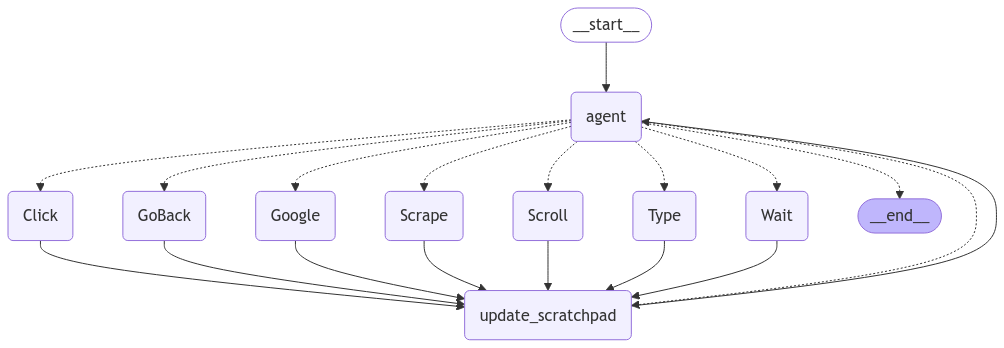

In [8]:
from IPython.display import Image, display

try:
    display(Image(web_agent.graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### the actual event loop


0: 736x1280 2 icons, 143.0ms
Speed: 7.1ms preprocess, 143.0ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)
Evaluating element at: (83.0, 37.00000190734863)
Evaluating element at: (266.50000381469727, 35.50000286102295)
Evaluating element at: (385.00000762939453, 37.000000953674316)
Evaluating element at: (507.00000381469727, 37.999999046325684)
Evaluating element at: (635.0000114440918, 36.000000953674316)
Evaluating element at: (751.0000152587891, 36.99999952316284)
Evaluating element at: (869.0, 37.999999046325684)
Evaluating element at: (1000.9999923706055, 36.99999952316284)
Evaluating element at: (635.0000305175781, 150.99999618530273)
Evaluating element at: (631.0, 209.00000190734863)
Evaluating element at: (529.9999847412109, 339.9999990463257)
Evaluating element at: (323.9999885559082, 368.9999942779541)
Evaluating element at: (529.9999923706055, 369.00000190734863)
Evaluating element at: (735.9999923706055, 369.9999990463257)
Evaluating element at: (941.9
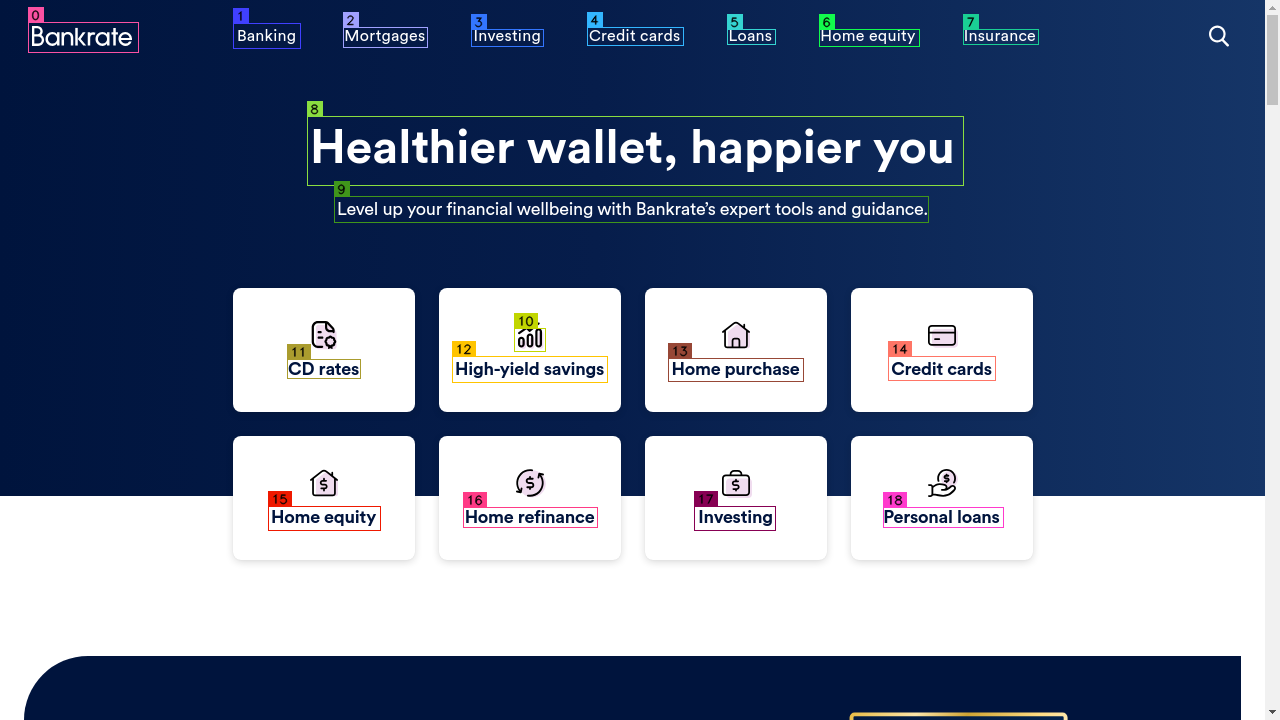

[2024-12-17 11:44:58,399: INFO: logger: Step 1 | Action: Click | Action Args: [2]]



0: 736x1280 9 icons, 146.7ms
Speed: 3.0ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)
Evaluating element at: (66.0, 36.00000190734863)
Evaluating element at: (264.00000381469727, 37.999999046325684)
Evaluating element at: (382.00000381469727, 37.999999046325684)
Evaluating element at: (502.5, 36.00000286102295)
Evaluating element at: (632.0000076293945, 36.000000953674316)
Evaluating element at: (746.9999771118164, 36.99999952316284)
Evaluating element at: (865.0, 37.999999046325684)
Evaluating element at: (996.9999923706055, 36.99999952316284)
Evaluating element at: (416.0, 91.00000190734863)
Evaluating element at: (554.9999847412109, 91.00000190734863)
Evaluating element at: (751.0, 91.00000190734863)
Evaluating element at: (240.99999618530273, 164.00000190734863)
Evaluating element at: (498.0, 158.99999952316284)
Evaluating element at: (775.0, 158.99999904632568)
Evaluating element at: (242.99999237060547, 203.99999141693115)
Evaluating ele
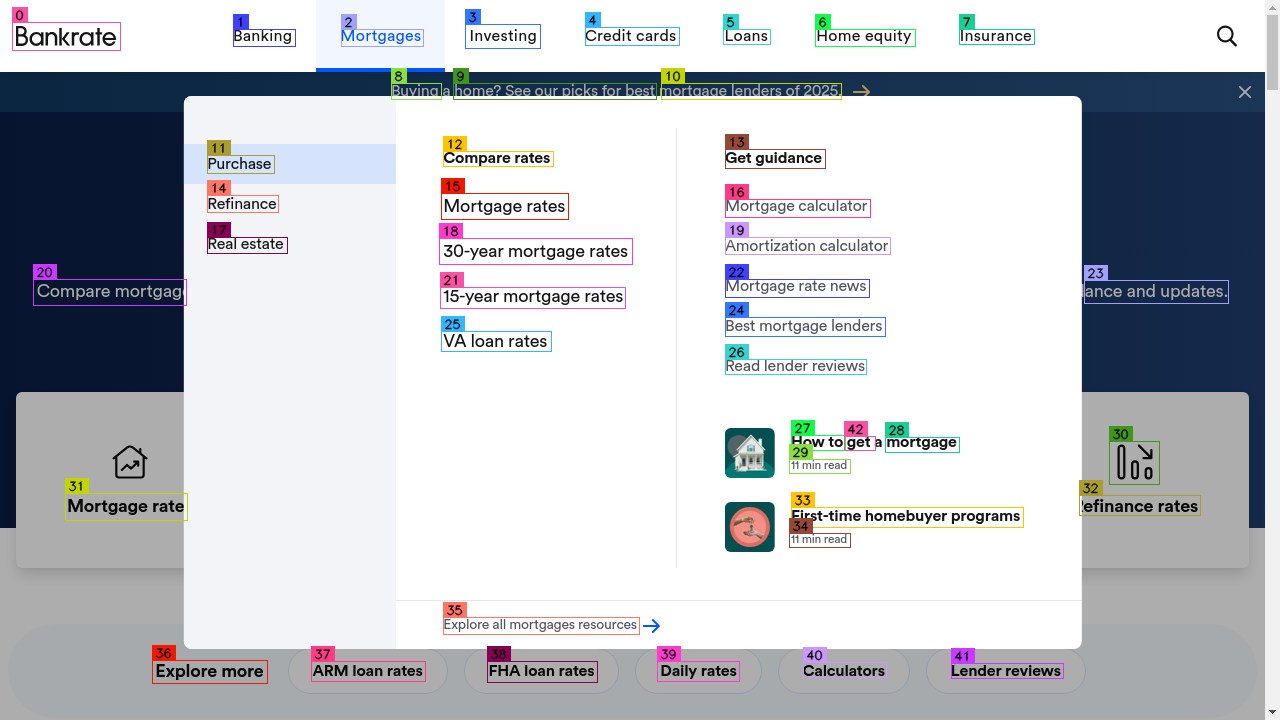

[2024-12-17 11:45:08,590: INFO: logger: Step 2 | Action: Click | Action Args: [31]]



0: 736x1280 5 icons, 139.5ms
Speed: 3.2ms preprocess, 139.5ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)
Evaluating element at: (66.0, 36.00000190734863)
Evaluating element at: (264.00000381469727, 37.999999046325684)
Evaluating element at: (382.00000381469727, 37.999999046325684)
Evaluating element at: (504.0, 37.999999046325684)
Evaluating element at: (632.0000076293945, 36.000000953674316)
Evaluating element at: (746.9999771118164, 36.99999952316284)
Evaluating element at: (865.0, 37.999999046325684)
Evaluating element at: (996.9999923706055, 36.99999952316284)
Evaluating element at: (633.0, 136.99999618530273)
Evaluating element at: (261.0, 203.99999141693115)
Evaluating element at: (491.0, 204.49999809265137)
Evaluating element at: (743.9999847412109, 204.49999809265137)
Evaluating element at: (917.9999923706055, 204.99998426437378)
Evaluating element at: (1054.000015258789, 201.99999713897705)
Evaluating element at: (924.0, 306.99999952316284)
Evaluating e
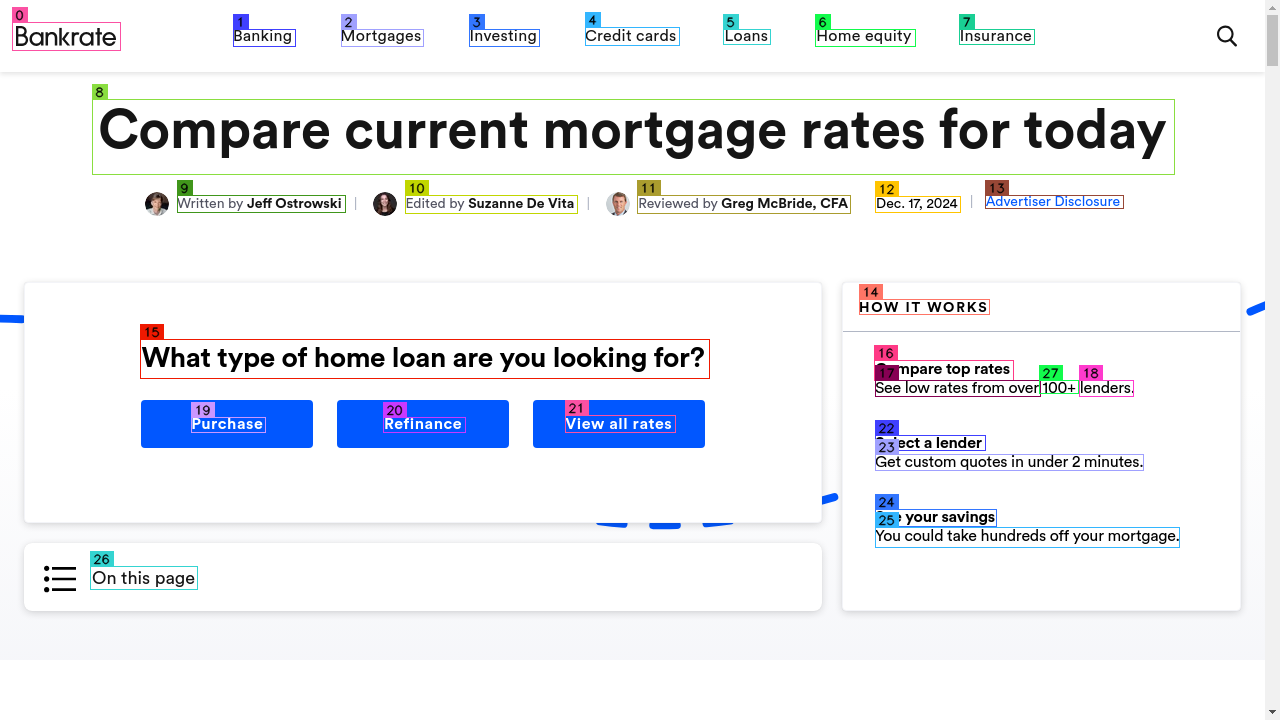

[2024-12-17 11:45:20,537: INFO: logger: Step 3 | Action: Click | Action Args: [1]]



0: 736x1280 5 icons, 232.4ms
Speed: 4.8ms preprocess, 232.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Evaluating element at: (66.0, 36.00000190734863)
Evaluating element at: (264.00000381469727, 37.999999046325684)
Evaluating element at: (382.00000381469727, 37.999999046325684)
Evaluating element at: (503.49999618530273, 36.00000286102295)
Evaluating element at: (632.0000076293945, 36.000000953674316)
Evaluating element at: (746.9999771118164, 36.99999952316284)
Evaluating element at: (865.0, 37.999999046325684)
Evaluating element at: (996.9999923706055, 36.99999952316284)
Evaluating element at: (389.99998474121094, 91.00000190734863)
Evaluating element at: (681.9999847412109, 90.00000190734863)
Evaluating element at: (262.50000762939453, 163.50000095367432)
Evaluating element at: (501.0, 158.99999952316284)
Evaluating element at: (835.0, 158.99999904632568)
Evaluating element at: (211.99999809265137, 204.99998426437378)
Evaluating element at: (518.0000076293
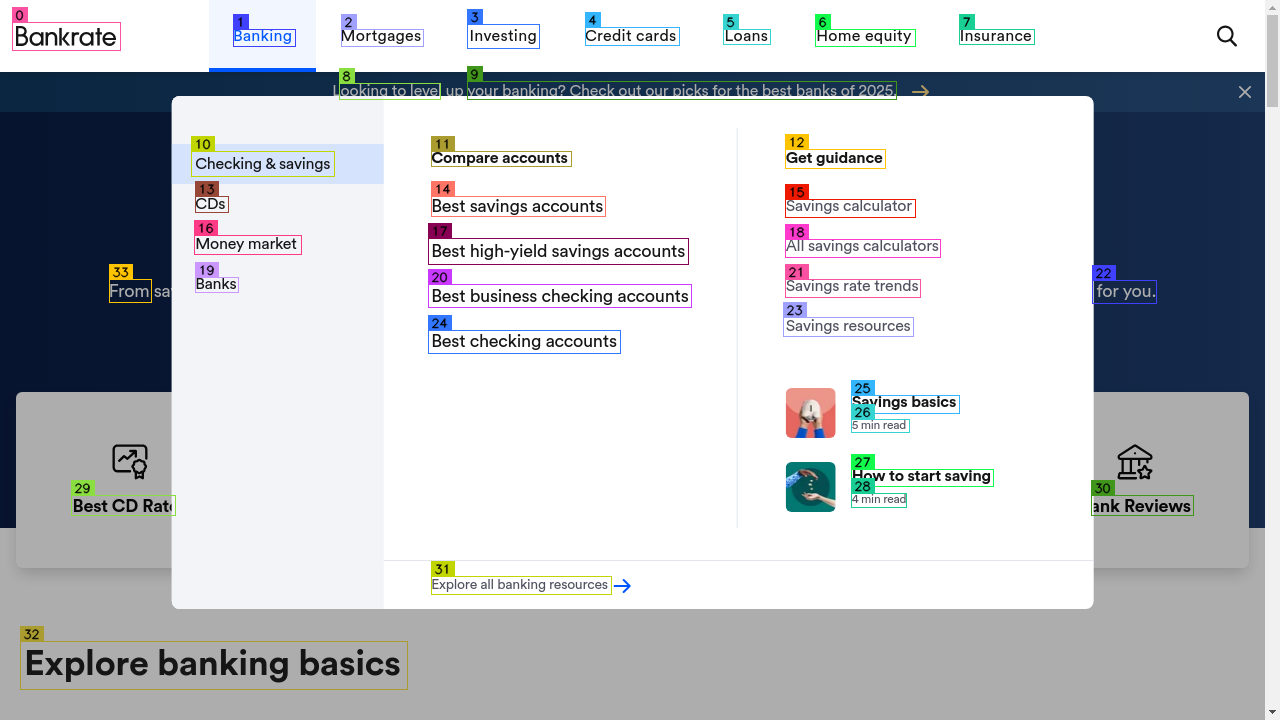

[2024-12-17 11:45:28,017: INFO: logger: Step 3 | Action: Error | Action Args: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}]
[2024-12-17 11:45:28,017: ERROR: logger: Error: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}]
[2024-12-17 11:45:28,020: INFO: logger: Structured logs saved to JSON at Logs/structured_logs.json]
[2024-12-17 11:45:28,021: INFO: logger: Structured log tools saved to JSON at Logs/tool_logs.json]


InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}

In [9]:

# Define the entry point for running the agent
async def main():
    start_url = "https://www.bankrate.com/"  # "https://www.google.com"
    question = "Please find the best mortgage rate available to me using bankrate.com. My zip code is 90210 and the purchase price is $400,000 with a down payment of $85,000. My credit score is 800."  # "What is the weather like in London?"
    max_steps = 100  # Adjust as needed
    headless = False  # Set to True if you don't need to see the browser

    # Run the agent and capture the final answer
    final_answer = await web_agent.run(start_url, question, max_steps, headless)
    
    # Print the final answer
    print("\nFinal Answer:", final_answer)

# Run the main function in the asyncio event loop
await main()